<a href="https://colab.research.google.com/github/Tuxliri/RL_rocket/blob/ppo-6DOF/run_colab_6DOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone --branch ppo-6DOF https://github.com/Tuxliri/RL_rocket.git

Cloning into 'RL_rocket'...
remote: Enumerating objects: 1927, done.
remote: Counting objects: 100% (611/611), done.
remote: Compressing objects: 100% (324/324), done.
remote: Total 1927 (delta 328), reused 525 (delta 287), pack-reused 1316
Receiving objects: 100% (1927/1927), 14.62 MiB | 17.47 MiB/s, done.
Resolving deltas: 100% (1152/1152), done.


In [2]:
!pip install stable-baselines3==1.5.0

!pip install -e RL_rocket/.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 4.9 MB/s 
     |████████████████████████████████| 1.5 MB 53.4 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616826 sha256=edb12be220d21149dbad683025d3529fc64c3ba947c792be727d705dcf4df46b
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.1
    Uninstalling gym-0.25.1:
      Successfully uninstalled gym-0.25.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/RL_rocket
     |████████████████████████████████| 21.8 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 51.4 MB/s 
     |████████████████████████████████| 1.5 MB 64.7 MB/s 
     |████████████████████████████████| 88.3 MB 108 kB/s 

**IMPORT ALL THE NEEDED PACKAGES**

In [6]:
import gym
%cd RL_rocket/
import my_environment

!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

import pyvista as pv
pv.start_xvfb()

[Errno 2] No such file or directory: 'RL_rocket/'
/content/RL_rocket


In [9]:
env = gym.make('my_environment/Falcon6DOF-v0')

env.reset()
img=env.render(mode='rgb_array')

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
/usr/local/lib/python3.7/dist-packages/pyvista/core/pointset.py:317: PyvistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyvistaDeprecationWarning)


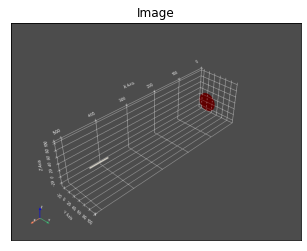

In [12]:
from matplotlib import pyplot as plt
from IPython.display import Image

plt.imshow(img)
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Execute the training

**Environment definition**

Here we define the environment, setting up the initial conditions, the range over which the initial conditions are generated and the timestep of the simulation.

In [ ]:
# Choose the folder to store tensorboard logs
TENSORBOARD_LOGS_DIR = "./logs"

config = {
    "env_id" : "my_environment/Falcon3DOF-v0",
    "policy_type": "MlpPolicy",
    "total_timesteps": int(2e6),
    "timestep" : 0.05,
    "max_time" : 100,
    "RANDOM_SEED" : 42,
    "initial_conditions" : [-1600, 2000, np.pi*3/4, 180, -90, 0, 50e3],
    "initial_conditions_range" : [5,50,0,0,0,0,1e3],
    "reward_coefficients" : {
                            "alfa" : -0.01, 
                            "beta" : 0,
                            "delta" : -5,
                            "eta" : 0.2,
                            "gamma" : -10,
                            "kappa" : 10,
                            "xi" : 0.004,
                            "waypoint" : 30,
                            "landing_radius" : 30
                            },
}

config["max_ep_timesteps"] = int(config["max_time"]/config["timestep"])
config["eval_freq"] = int(config["total_timesteps"]/20)

run = wandb.init(
    project="RL_rocket",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
)

def make_env():
    env = gym.make(
    config["env_id"],
    IC=config["initial_conditions"],
    ICRange=config["initial_conditions_range"],
    timestep=config["timestep"],
    seed=config["RANDOM_SEED"],
    reward_coeff=config["reward_coefficients"]
    )
    
    # Define a new custom action space with only three actions:
    # - no thrust
    # - max thrust gimbaled right
    # - max thrust gimbaled left
    # - max thrust downwards
    
    # env = DiscreteActions3DOF(env)
    env = TimeLimit(env, max_episode_steps=config["max_ep_timesteps"])
    env = Monitor(
        env,
        allow_early_resets=True,
        filename="logs_PPO",
        )
    return env

In [ ]:
wandb.run.log_code(root = '/content/RL_rocket/my_environment', name = 'environment')

In [ ]:
env=make_env()
model = PPO(
    config["policy_type"],
    env,
    tensorboard_log=f"runs/{run.id}",
    verbose=1,
    seed=config["RANDOM_SEED"],
    ent_coef=0.01,
    )

def make_eval_env(training_env = env):
        return RecordVideoFigure(training_env, video_folder=f"videos/{run.id}",
        image_folder=f"images/{run.id}", episode_trigger= lambda x: x%5==0 )

  
eval_env = DummyVecEnv([make_eval_env])
            
callbacksList = [
    EvalCallback(
        eval_env,
        eval_freq = config["eval_freq"],
        n_eval_episodes = 5,
        render=False,
        deterministic=True,
        ),
    WandbCallback(
        model_save_path=f"models/{run.id}",
        verbose=2,
        gradient_save_freq=10000
        )
    ]

model.learn(
    total_timesteps=config["total_timesteps"],
    callback=callbacksList
)

In [ ]:
def make_env(config):
    env = gym.make(
    config["env_id"],
    IC=config["initial_conditions"],
    ICRange=config["initial_conditions_range"],
    timestep=config["timestep"],
    seed=config["RANDOM_SEED"]
    )
    # Anneal the reward (remove v_targ following reward)
    env = RewardAnnealing(env, thrust_penalty = 0.004)

    # Define a new custom action space with only three actions:
    # - no thrust
    # - max thrust gimbaled right
    # - max thrust gimbaled left
    # - max thrust downwards
    
    # env = DiscreteActions3DOF(env)
    env = TimeLimit(env, max_episode_steps=config["max_ep_timesteps"])
    return env

env=make_env(config)

def make_eval_env(training_env=env):
    return RecordVideoFigure(training_env, video_folder=f"videos/{run.id}",
            image_folder=f"images/{run.id}", episode_trigger= lambda x: x%5==0 )

eval_env = DummyVecEnv([make_eval_env])

callbacksList = [
    EvalCallback(
        eval_env,
        eval_freq = config["eval_freq"],
        n_eval_episodes = 5,
        render=False,
        deterministic=True,
        ),
    WandbCallback(
        model_save_path=f"models/{run.id}",
        verbose=2,
        gradient_save_freq=10000
        ),
]     
    
model.set_env(env)
# model.learn(
#     total_timesteps=config["total_timesteps"]*2,
#     callback=callbacksList
# )

run.finish()